# Overview

In this project, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/)

## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use Alternating Least Squares (ALS) algorithm to make movie predictions


## [Alternating Least Squares](https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf)
ALS is one of the low rank matrix approximation algorithms for collaborative filtering. ALS decomposes user-item matrix into two low rank matrixes: user matrix and item matrix. In collaborative filtering, users and products are described by a small set of latent factors that can be used to predict missing entries. And ALS algorithm learns these latent factors by matrix factorization


## Data Sets
I use [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.

## Project Content
1. Load Data
2. Spark SQL and OLAP
3. Spark ALS based approach for training model
4. ALS Model Selection and Evaluation
5. Model testing
6. Make movie recommendation to myself

In [1]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

23/12/02 15:39:33 WARN Utils: Your hostname, harsh-raj-Mi-NoteBook-14 resolves to a loopback address: 127.0.1.1; using 10.150.43.173 instead (on interface wlp0s20f3)
23/12/02 15:39:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/02 15:39:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load Data

In [3]:
movies = spark.read.load("data.csv", format='csv', header=True, inferSchema=True)
ratings = spark.read.load("final_ratings.csv", format='csv', header=True, inferSchema=True)
links = spark.read.load("data.csv", format='csv', header=True, inferSchema=True)
tags = spark.read.load("new_data.csv", format='csv', header=True, inferSchema=True)

### basic inspection

In [4]:
movies.show(3)

+--------------------+--------------------+------+--------------------+------+----------+-----+--------+--------+--------------------+------+-------------+--------------------+--------------------+
|                name|            overview|    id|         poster_path|rating|vote_count|adult|director|producer|             creator|actors|year_released|              genres|            keywords|
+--------------------+--------------------+------+--------------------+------+----------+-----+--------+--------+--------------------+------+-------------+--------------------+--------------------+
|          Tagesschau|German daily news...| 94722|https://image.tmd...| 7.094|       171|False|      []|      []|                  []|    []|       1952.0|            ['News']|['German', 'daily...|
|       Elas por Elas|Seven friends who...|219109|https://image.tmd...| 6.533|        15|False|      []|      []|['Alessandro Mars...|    []|       2023.0|['Comedy', 'Myste...|['Seven', 'friend...|
|Temptatio

In [5]:
ratings.show(3)

+--------------+-----+------+------+
|          name| tvId|userId|rating|
+--------------+-----+------+------+
|Rick and Morty|60625|   106|   9.0|
|Rick and Morty|60625|  1576|  10.0|
|Grey's Anatomy| 1416|     3|   1.0|
+--------------+-----+------+------+
only showing top 3 rows



In [6]:
links.show(3)

+--------------------+--------------------+------+--------------------+------+----------+-----+--------+--------+--------------------+------+-------------+--------------------+--------------------+
|                name|            overview|    id|         poster_path|rating|vote_count|adult|director|producer|             creator|actors|year_released|              genres|            keywords|
+--------------------+--------------------+------+--------------------+------+----------+-----+--------+--------+--------------------+------+-------------+--------------------+--------------------+
|          Tagesschau|German daily news...| 94722|https://image.tmd...| 7.094|       171|False|      []|      []|                  []|    []|       1952.0|            ['News']|['German', 'daily...|
|       Elas por Elas|Seven friends who...|219109|https://image.tmd...| 6.533|        15|False|      []|      []|['Alessandro Mars...|    []|       2023.0|['Comedy', 'Myste...|['Seven', 'friend...|
|Temptatio

In [7]:
tags.show(3)

+----------------+------+--------------------+
|            name|    id|                tags|
+----------------+------+--------------------+
|      Tagesschau| 94722|News  German dail...|
|   Elas por Elas|219109|Comedy Mystery So...|
|Gran hermano VIP| 82250|Reality   3.818  ...|
+----------------+------+--------------------+
only showing top 3 rows



## Spark SQL and OLAP

Below are the questions I'd like to ask:
1. What are the ratings?
2. What is minimum number of ratings per user and minimum number of ratings per movie?
3. How many movies are rated by only one user?
4. What is the total number of users in the data sets?
5. What is the total number of movies in the data sets?
6. How many movies are rated by users? List movies not rated yet?
7. List all movie genres
8. Find out the number of movies for each category
9. Calculate the total rating count for every movie
10. Get a count plot for each rating

What are the ratings?

In [8]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


What is minimum number of ratings per user and minimum number of ratings per movie?

In [9]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("tvId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per movie is 1


How many movies are rated by only one user?

In [10]:
tmp1 = sum(ratings.groupBy("tvId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('tvId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

574 out of 865 movies are rated by only one user


What is the total number of users in the data sets?

In [11]:
tmp = ratings.select('userID').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 390 distinct users in the data sets


What is the total number of movies in the data sets?

In [12]:
tmp = movies.select('id').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

We have a total of 9179 distinct movies in the data sets


How many movies are rated by users? List movies not rated yet?

In [13]:
tmp1 = movies.select('id').distinct().count()
tmp2 = ratings.select('tvId').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 865 distinct movies that are rated by users in ratings table
We have 8314 movies that are not rated yet


In [14]:
# create a temp SQL table view for easier query
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
print('List movies that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
spark.sql(
    "SELECT id, name "
    "FROM movies "
    "WHERE id NOT IN (SELECT distinct(tvId) FROM ratings)"
).show(20)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

List movies that are not rated yet: 


+------+--------------------+
|    id|                name|
+------+--------------------+
| 94722|          Tagesschau|
|219109|       Elas por Elas|
|238766|Temptation Island...|
|209265|      Land of Desire|
|218145|        Mom for rent|
|213026|               Fuzue|
|202411|Monarch: Legacy o...|
|101463|        Al rojo vivo|
| 91759|Come Home Love: L...|
|226773|         Senior High|
| 72879|    Tomorrow is Ours|
|206559|        Binnelanders|
|229947|  The Elegant Empire|
|232937|     Minas de Pasión|
| Boháč|The show describe...|
|235484|          Suidooster|
|   549|         Law & Order|
|233643|Secret Mission: S...|
|230525|Unpredictable Family|
| 95479|      Jujutsu Kaisen|
+------+--------------------+
only showing top 20 rows



List all movie genres

In [15]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import round
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType
movies = movies.dropna(subset=["genres"])
movies = movies.dropna(subset=["name"])
movies = movies.dropna(subset=["id"])
movies = movies.withColumn("rating", when(col("rating").isNotNull(), col("rating").cast("int")).otherwise(0))
movies = movies.withColumn("id", when(col("id").isNotNull(), col("id").cast("int")).otherwise(0))\
# Remove square brackets and single quotes
movies = movies.withColumn("genres", regexp_replace("genres", "[\[\]']", ""))
movies.show()

+--------------------+--------------------+------+--------------------+------+----------+--------------------+--------+--------------------+--------------------+------+-------------+--------------------+--------------------+
|                name|            overview|    id|         poster_path|rating|vote_count|               adult|director|            producer|             creator|actors|year_released|              genres|            keywords|
+--------------------+--------------------+------+--------------------+------+----------+--------------------+--------+--------------------+--------------------+------+-------------+--------------------+--------------------+
|          Tagesschau|German daily news...| 94722|https://image.tmd...|     7|       171|               False|      []|                  []|                  []|    []|       1952.0|                News|['German', 'daily...|
|       Elas por Elas|Seven friends who...|219109|https://image.tmd...|     6|        15|           

In [16]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split(','), ArrayType(StringType()))
# query
print('All distinct genres: ')
num_distinct_genres = movies.select(explode(splitter("genres")).alias("genres")).distinct().count()
print(f"Number of distinct genres: {num_distinct_genres}")
movies.select(explode(splitter("genres")).alias("genres")).distinct().show(30)

All distinct genres: 


Number of distinct genres: 3473
+-------------+
|       genres|
+-------------+
|   unexpected|
|          8.5|
|      dealing|
|      Navidad|
|  conjunction|
|       1974.0|
|       washer|
|   Jack Kenny|
|     McCarthy|
|          ITV|
|       losing|
|    sclerosus|
|    surviving|
|     children|
|      cartoon|
|     premiere|
| Gautam Hegde|
|       2013.0|
|       sketch|
| John Chernin|
|     channels|
|          Mae|
|          Amy|
|       embark|
|          mad|
|  Nickelodeon|
|       Agents|
|         STAR|
|       Spider|
|      Academy|
+-------------+
only showing top 30 rows



Find out the number of movies for each category

In [17]:
output_path = "distinct_genres.csv"

# Write the DataFrame to a CSV file
movies.select(explode(splitter("genres")).alias("genres")).distinct().write.csv(output_path, header=True, mode="overwrite")

In [18]:
print('Counts of movies per genre')
movies.select('id', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show(100)

Counts of movies per genre


+-------------------+-----+
|             genres|count|
+-------------------+-----+
|              Drama| 1935|
|              Drama| 1922|
|          Animation| 1587|
|             Comedy| 1373|
|   Sci-Fi & Fantasy| 1280|
|             Comedy| 1230|
| Action & Adventure| 1045|
|            Mystery|  699|
|                   |  638|
| Action & Adventure|  590|
|          Animation|  498|
|              Crime|  479|
|              Crime|  469|
|             Family|  431|
|   Sci-Fi & Fantasy|  387|
|               Kids|  355|
|            Reality|  350|
|        Documentary|  269|
|            Mystery|  178|
|             Family|  177|
|     War & Politics|  134|
|             series|  129|
|               Soap|  107|
|               Kids|  104|
|               Soap|  103|
|               Talk|   93|
|              False|   65|
|            Reality|   61|
|               Talk|   57|
|        Documentary|   54|
|            Western|   52|
|         television|   44|
|              aired

## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [19]:
# load data
movie_rating = sc.textFile("ratings_data.csv")
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(60625, 106, 9), (60625, 1576, 10), (1416, 3, 1)]

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [20]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[203] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [21]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [22]:
# hyper-param config
num_iterations = 10
ranks = [20, 22, 24, 26, 28, 30]
reg_params = [0.5, 0.6]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

23/12/02 15:40:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


20 latent factors and regularization = 0.5: validation RMSE is 5.440518056537881


20 latent factors and regularization = 0.6: validation RMSE is 5.437096470496647


22 latent factors and regularization = 0.5: validation RMSE is 5.65912750855417


22 latent factors and regularization = 0.6: validation RMSE is 5.661870348353117


24 latent factors and regularization = 0.5: validation RMSE is 5.296479585328305


24 latent factors and regularization = 0.6: validation RMSE is 5.287159275199519


26 latent factors and regularization = 0.5: validation RMSE is 5.550163951479252


26 latent factors and regularization = 0.6: validation RMSE is 5.536330220005044


28 latent factors and regularization = 0.5: validation RMSE is 5.327023953841956


28 latent factors and regularization = 0.6: validation RMSE is 5.328137927735551


30 latent factors and regularization = 0.5: validation RMSE is 5.477059456249168


30 latent factors and regularization = 0.6: validation RMSE is 5.468654372619848

The best model has 24 latent factors and regularization = 0.6
Total Runtime: 96.37 seconds


### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [23]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

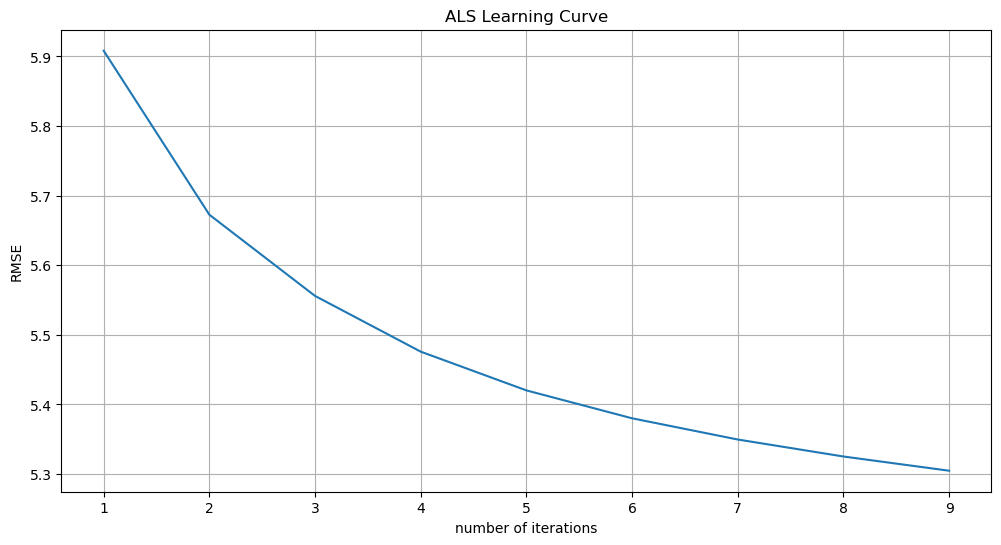

In [24]:
# create an array of num_iters
iter_array = list(range(1,10))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.6, 24)

After 10 iterations, alternating gradient descend starts to converge at an error around 5

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [25]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', error)

The out-of-sample RMSE of rating predictions is 5.496664146071237


### Make movie recommendation to myself
We need to define a function that takes new user's movie rating and output top 10 recommendations

In [26]:
def get_movieId(df_movies, fav_movie_list):
    """
    return all movieId(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieId_list: list of movieId(s)
    """
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(movies.name.like('%{}%'.format(movie))) \
            .select('id') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_movies.filter(movies.movieId.isin(topn_ids)) \
                    .select('name') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

Let's pretend I am a new user in this recommender system. I will input a handful of my all-time favorite movies into the system. And then the system should output top N movie recommendations for me to watch

In [27]:
# my favorite movies
my_favorite_movies = ['Loki']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 26, 'lambda_': 0.5}, 
    ratings_data=rating_data, 
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, name in enumerate(recommends):
    print('{0}: {1}'.format(i+1, name))

Traceback (most recent call last):=>                               (6 + 8) / 14]
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/recommendation.py", line 51, in __reduce__
    return Rating, (int(self.user), int(self.product), float(self.rating))
                                    ^^^^^^^^^^^^^^^^^
Type

Py4JJavaError: An error occurred while calling o2256.trainALSModel.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 3240.0 failed 1 times, most recent failure: Lost task 5.0 in stage 3240.0 (TID 6303) (10.150.43.173 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/recommendation.py", line 51, in __reduce__
    return Rating, (int(self.user), int(self.product), float(self.rating))
                                    ^^^^^^^^^^^^^^^^^
TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 278, in dump_stream
    bytes = self.serializer.dumps(vs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 469, in dumps
    raise pickle.PicklingError(msg)
_pickle.PicklingError: Could not serialize object: TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$ConcatIterator.hasNext(Iterator.scala:224)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1293)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:988)
	at org.apache.spark.mllib.recommendation.ALS.run(ALS.scala:256)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainALSModel(PythonMLLibAPI.scala:485)
	at jdk.internal.reflect.GeneratedMethodAccessor108.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/recommendation.py", line 51, in __reduce__
    return Rating, (int(self.user), int(self.product), float(self.rating))
                                    ^^^^^^^^^^^^^^^^^
TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 278, in dump_stream
    bytes = self.serializer.dumps(vs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsh-raj/anaconda3/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 469, in dumps
    raise pickle.PicklingError(msg)
_pickle.PicklingError: Could not serialize object: TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$ConcatIterator.hasNext(Iterator.scala:224)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


This list of movie recommendations look completely different than the list from my previous **KNN** model recommender. Not only it recommends movies outside of years between 2007 and 2009 periods, but also recommends movies that were less known. So this can offer users some elements of suprise so that users won't get bored by getting the same popular movies all the time.

So this list of recommendations can be blended into the previous list of recommendations from **KNN** model recommender